In [1]:
import numpy as np
import pandas as pd
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold",  labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

In [4]:
class Course:
    @staticmethod
    def load_data():
        df = pd.read_csv("../../input/fe-course-data/movielens1m.csv")
        df = df.astype(np.uint8, errors='ignore')
        return df

    @staticmethod
    def split_df_for_encode(df, y_label):
        X = df.copy()

        X_encode = X.sample(frac=0.25)
        y_encode = X_encode.pop(y_label)

        # Training split
        X_pretrain = df.drop(X_encode.index)
        y_train = X_pretrain.pop(y_label)
        return (X_encode, y_encode), (X_pretrain, y_train)

    @staticmethod
    def get_m_estimate_encoder(X, y, col):
        encoder = MEstimateEncoder(cols=[col, ], m=5.0)
        # encoder.cols 可以获取 cols
        encoder.fit(X, y)
        return encoder

    @staticmethod
    def encode_m_estimate(encoder, X):
        return encoder.transform(X)

    @staticmethod
    def show_encoding_result(X, y, feature_label, y_label):
        plt.figure(dpi=90)
        # 显示 y 的不同值的出现次数分布图
        ax = sns.distplot(y, kde=False, norm_hist=True)
        # kdeplot, kernel density estimation, 核密度估计图
        ax = sns.kdeplot(X[feature_label], color='r', ax=ax)
        # 或者 sns.distplot(X[feature_label], color='r', ax=ax, kde=True, hist=False)
        # hist=True, histogram
        # kde=True, gaussian kernel density estimation 高斯核密度估计图
        # norm_hist=False, histogram 的 count 改成 density

        ax.set_xlabel(y_label)
        ax.legend(labels=[feature_label, y_label])

    @staticmethod
    def score_dataset(X, y, model=XGBRegressor()):
        for colname in X.select_dtypes(["category", "object"]):
            X[colname], _ = X[colname].factorize()
        score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_log_error")
        return - np.sqrt(score.mean())

    @staticmethod
    def find_object_features(df):
        return df.select_dtypes(["object"]).nunique()

    @staticmethod
    def get_value_counts(df, feature):
        return df[feature].value_counts()

In [5]:
df = Course.load_data()

In [6]:
y_label = "Rating"
(X_encode, y_encode), (X_pretrain, y_train) = Course.split_df_for_encode(df, y_label)

In [7]:
feature_label = "Zipcode"
encoder = Course.get_m_estimate_encoder(X_encode, y_encode, feature_label)

In [8]:
X_pretrain[feature_label]

0          b'50021'
3          b'60073'
6          b'60626'
8          b'08876'
9          b'78759'
             ...   
1000201    b'95014'
1000203    b'68108'
1000205    b'22032'
1000206    b'80916'
1000207    b'93428'
Name: Zipcode, Length: 750157, dtype: object

In [9]:
X_train = Course.encode_m_estimate(encoder, X_pretrain)

In [10]:
X_train[feature_label]

0          3.775963
3          3.643425
6          3.622035
8          3.688046
9          3.104265
             ...   
1000201    3.690880
1000203    3.592266
1000205    3.851232
1000206    3.637439
1000207    3.843361
Name: Zipcode, Length: 750157, dtype: float64

/Users/lxh/.virtualenv/alisa/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


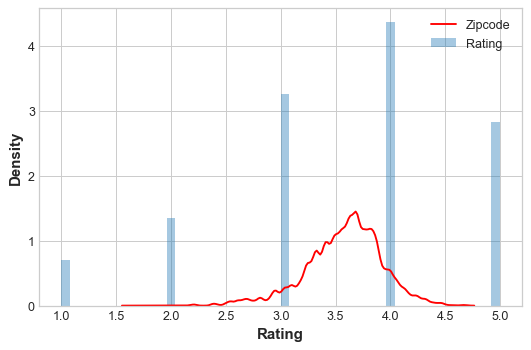

In [13]:
plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel(y_label)
ax.legend(labels=[feature_label, y_label])